In [6]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline
from pylab import rcParams

from numpy.random import normal, seed
from scipy.stats import norm

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

# Небольшое эконометрическое исследование.
В большей степени это попытка сделать эконометрику в питоне или просто попытка поиграть в песочнице.
В первой части имеющиеся данные - показатели акций General Electric и Cisco за период с 2006 по 2017 год.
Дневные данные, без пропусков кроме стандартных - выходные и праздничные дни.

Цель: посмотреть на данные, промоделировать различными процесами.

In [7]:
# Данные по компании General Electric
ge = pd.read_csv('ge.csv', index_col='Date', parse_dates=['Date'])
ge.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,35.10,35.40,34.80,35.37,33221400,GE
2006-01-04,35.35,35.40,35.10,35.32,24017300,GE
2006-01-05,35.27,35.35,35.10,35.23,18860400,GE
2006-01-06,35.38,35.53,35.19,35.47,22085300,GE
2006-01-09,35.40,35.43,35.24,35.38,20716900,GE


In [8]:
# Данные по компании Cisco
csco = pd.read_csv('csco.csv', index_col='Date', parse_dates=['Date'])
csco.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,17.21,17.49,17.18,17.45,55432166,CSCO
2006-01-04,17.48,17.93,17.46,17.85,80409776,CSCO
2006-01-05,17.94,18.48,17.93,18.35,118588943,CSCO
2006-01-06,18.51,18.88,18.47,18.77,122450979,CSCO
2006-01-09,18.97,19.11,18.92,19.06,78604868,CSCO


Цены закрытия акций за рассматриваемый период.

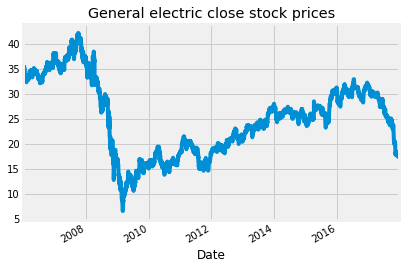

In [9]:
ge['Close'].plot(subplots=True)
plt.title('General electric close stock prices')
plt.show()

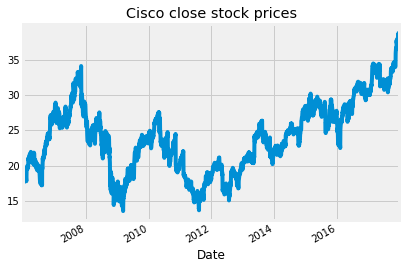

In [10]:
csco['Close'].plot(subplots=True)
plt.title('Cisco close stock prices')
plt.show()

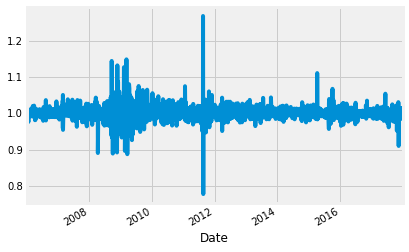

In [11]:
ge['Change'] = ge.High.div(ge.High.shift())
ge['Change'].plot()

Stock return

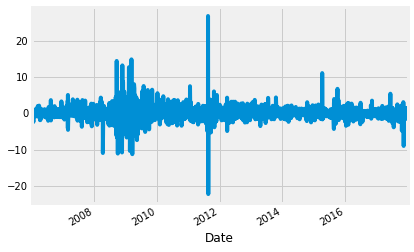

In [12]:
ge['Return'] = ge.Change.sub(1).mul(100)
ge['Return'].plot()

In [13]:
ge

,Open,High,Low,Close,Volume,Name,Change,Return
Date,,,,,,,,
2006-01-03,35.10,35.40,34.80,35.37,33221400,GE,NaN,NaN
2006-01-04,35.35,35.40,35.10,35.32,24017300,GE,1.000000,0.000000
2006-01-05,35.27,35.35,35.10,35.23,18860400,GE,0.998588,-0.141243
2006-01-06,35.38,35.53,35.19,35.47,22085300,GE,1.005092,0.509194
2006-01-09,35.40,35.43,35.24,35.38,20716900,GE,0.997185,-0.281452
...,...,...,...,...,...,...,...,...
2017-12-22,17.51,17.56,17.40,17.50,46370351,GE,0.992651,-0.734878
2017-12-26,17.45,17.66,17.40,17.43,55337926,GE,1.005695,0.569476
2017-12-27,17.46,17.63,17.31,17.38,60126681,GE,0.998301,-0.169875


Absolute change in successive rows (High stock price)

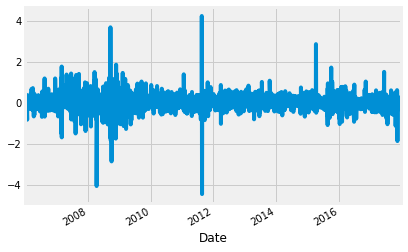

In [14]:
ge.High.diff().plot()

In [15]:
csco['Change'] = csco.High.div(csco.High.shift())
csco['Return'] = csco.Change.sub(1).mul(100)
csco

,Open,High,Low,Close,Volume,Name,Change,Return
Date,,,,,,,,
2006-01-03,17.21,17.49,17.18,17.45,55432166,CSCO,NaN,NaN
2006-01-04,17.48,17.93,17.46,17.85,80409776,CSCO,1.025157,2.515723
2006-01-05,17.94,18.48,17.93,18.35,118588943,CSCO,1.030675,3.067485
2006-01-06,18.51,18.88,18.47,18.77,122450979,CSCO,1.021645,2.164502
2006-01-09,18.97,19.11,18.92,19.06,78604868,CSCO,1.012182,1.218220
...,...,...,...,...,...,...,...,...
2017-12-22,38.52,38.74,38.47,38.55,11441622,CSCO,0.993333,-0.666667
2017-12-26,38.55,38.68,38.36,38.48,8186082,CSCO,0.998451,-0.154879
2017-12-27,38.54,38.65,38.45,38.56,10543034,CSCO,0.999224,-0.077559


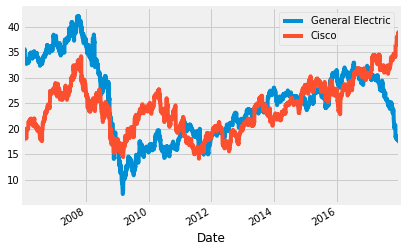

In [16]:
ge.High.plot()
csco.High.plot()
plt.legend(['General Electric', 'Cisco'])
plt.show()

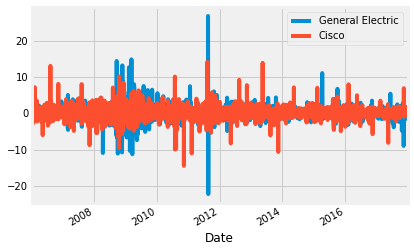

In [17]:
ge.Return.plot()
csco.Return.plot()
plt.legend(['General Electric', 'Cisco'])
plt.show()

Краткий вывод по полученным графикам.

General Electric -  как многоотраслевая корпорация в США, работающая с реальным сектором, понесла потери в стоимости акций после кризиса 2008 года. Что нельзя сказать про компанию Cisco - IT продукты всегда относительно востребованны на рынке. На графике возможна выражена явна сезонность в приобритенни информационных продуктов.

График приростов доходности говорит о том что акции двух компаний в целом сопостовимы по уровню дохода.

In [18]:
def do_plot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
    y - временной ряд
    lags - то сколько лагов будет входить ACF, PACF
    
    """
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout() 

Хм ура!
Попробуем посмотреть что у нас с ценами на акции.

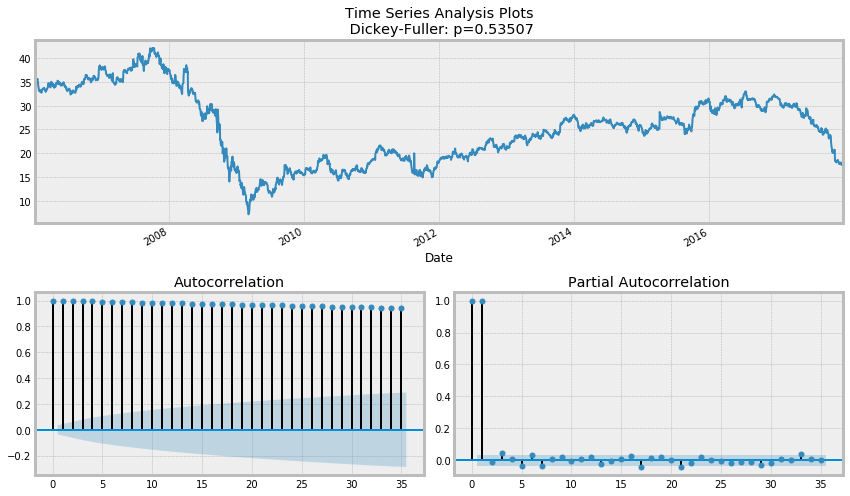

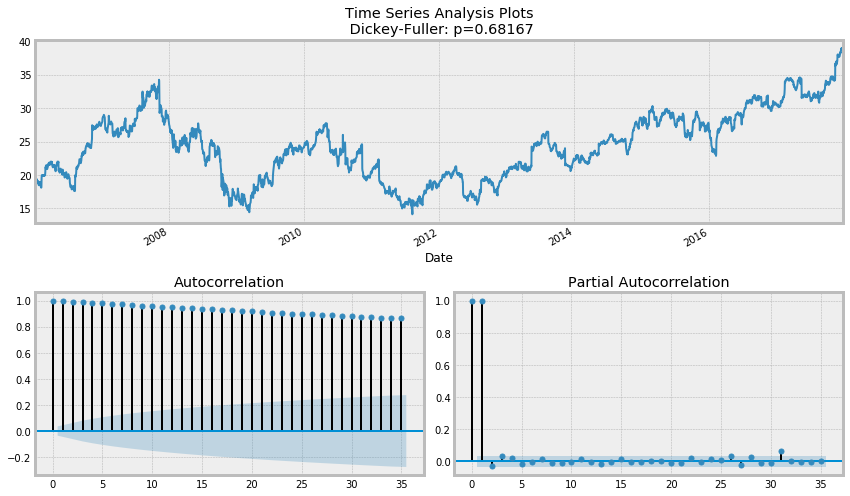

In [19]:
do_plot(ge.High)
do_plot(csco.High)

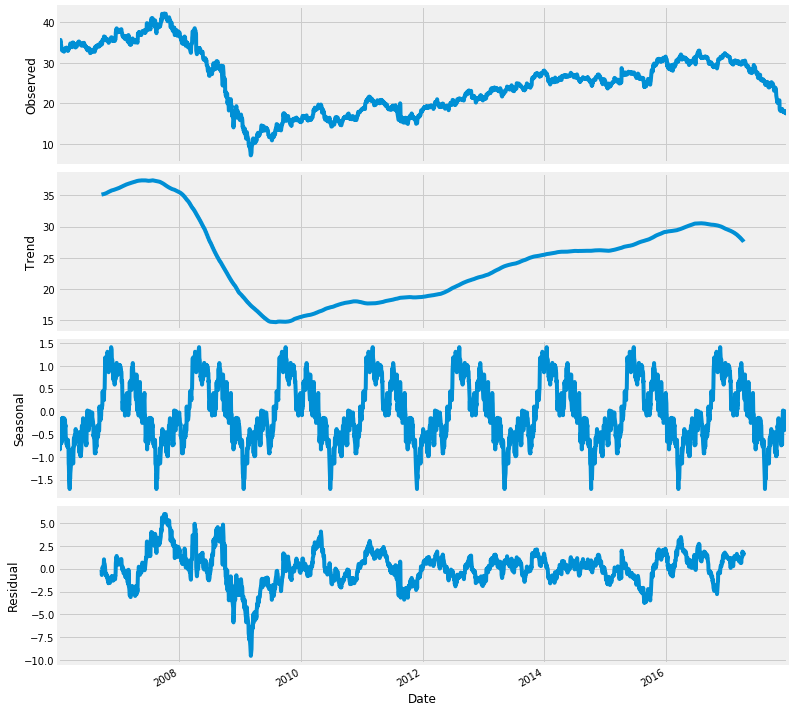

In [20]:
rcParams['figure.figsize'] = 11, 10
decomposed_ge_volume = sm.tsa.seasonal_decompose(ge["High"],freq=360) # 360 - 1 год
figure = decomposed_ge_volume.plot()
plt.show()

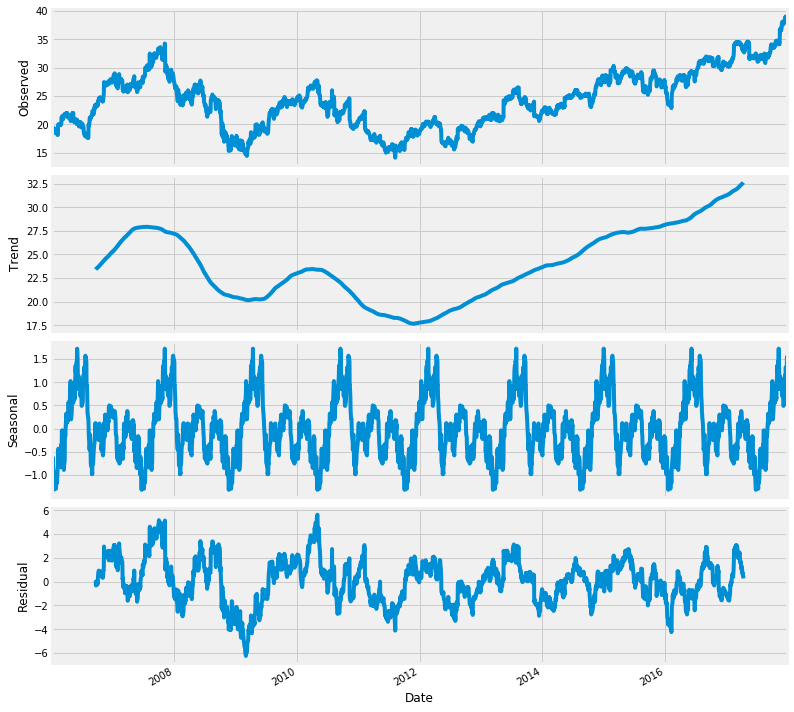

In [21]:
rcParams['figure.figsize'] = 11, 10
decomposed_csco_volume = sm.tsa.seasonal_decompose(csco["High"],freq=360) 
figure = decomposed_csco_volume.plot()
plt.show()

По ADF тесту оба ряда не стационарны.
Если посмотреть более детально графики:
* то действительно есть сезонность
* остатки распределены тоже со скосом вниз (отсутсвие нормальности)
* графики шумов неоднородны, представляют явные выбросы
По смещённым графикам Observation чётко видны тренды в поведение цен акций компаний.

Применим первые разности для остационаривания процессов.

In [22]:
ge_diff = ge.High - ge.High.shift(1)
csco_diff = csco.High - csco.High.shift(1)

ge_diff = ge_diff.drop(ge_diff.index[0])
csco_diff = csco_diff.drop(csco_diff.index[0])
csco_diff

Date
2006-01-04    0.44
2006-01-05    0.55
2006-01-06    0.40
2006-01-09    0.23
2006-01-10    0.04
              ... 
2017-12-22   -0.26
2017-12-26   -0.06
2017-12-27   -0.03
2017-12-28    0.08
2017-12-29   -0.11
Name: High, Length: 3018, dtype: float64

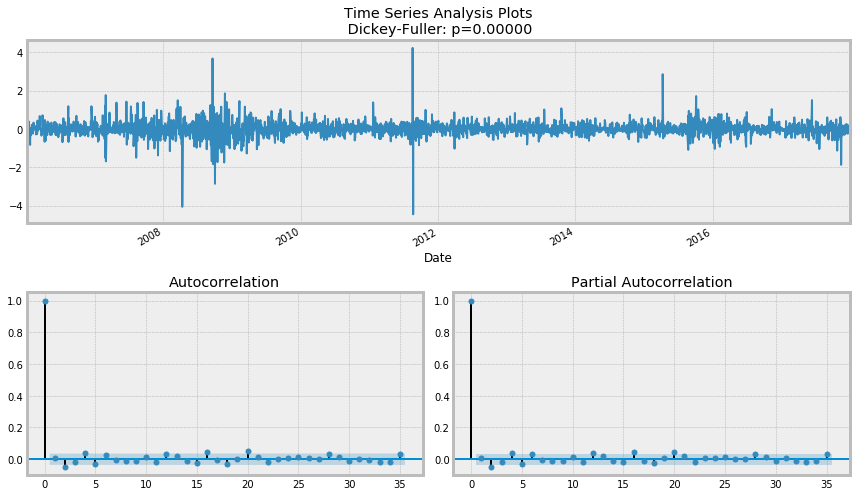

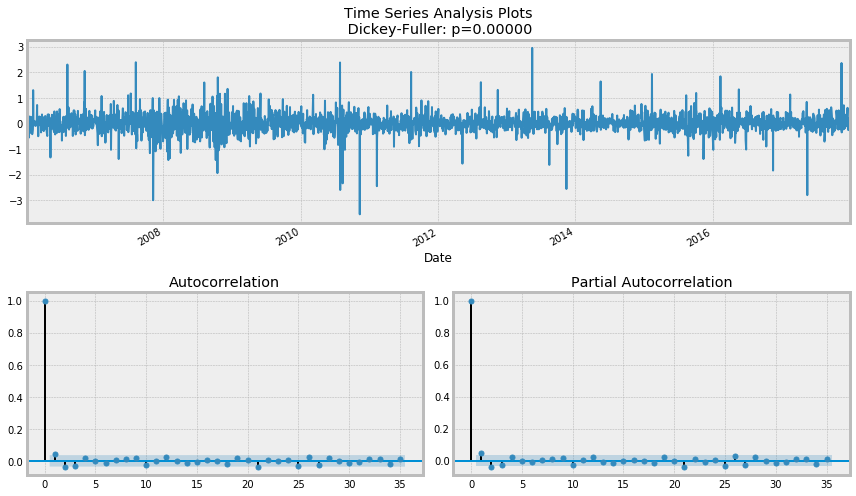

In [23]:
do_plot(ge_diff)
do_plot(csco_diff)

Остационарили ряды путём прироста, теперь с ними можно будет достаточно просто работать. 

Предположительно оба процесса AR - 1, MA - 1.

MA компоненту определяем по значимым компонентам ACF, AR - по PACF.

## Немного поиграем со сглаживанием рядов и сдвигами

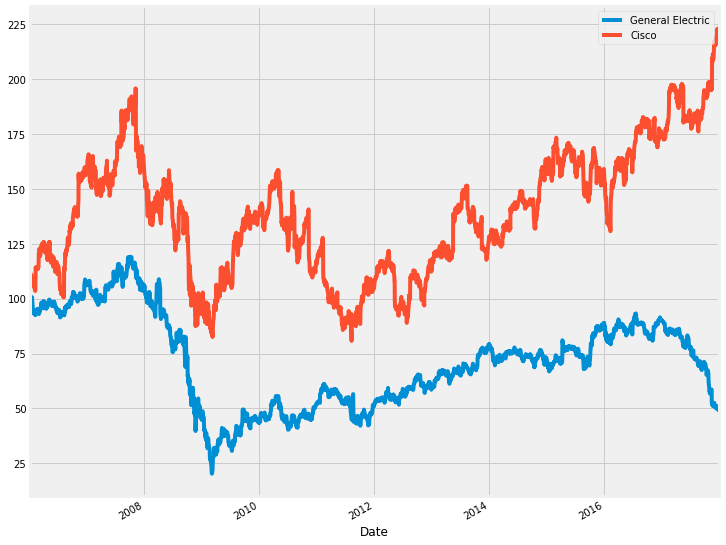

In [24]:
# Предварительно вставим нормализацию
normalized_ge = ge.High.div(ge.High.iloc[0]).mul(100)
normalized_csco = csco.High.div(csco.High.iloc[0]).mul(100)
normalized_ge.plot()
normalized_csco.plot()
plt.legend(['General Electric', 'Cisco'])
plt.show()

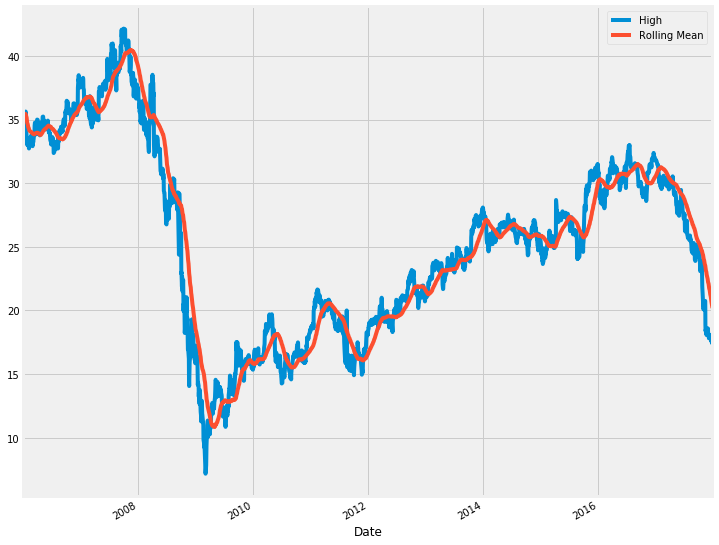

In [25]:
rolling_ge = ge.High.rolling('90D').mean() # Окно в 90 дней
ge.High.plot()
rolling_ge.plot()
plt.legend(['High','Rolling Mean'])
plt.show()

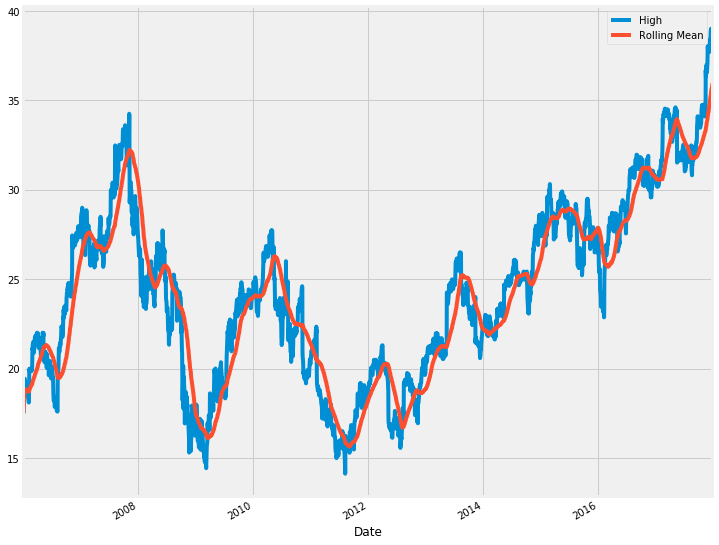

In [26]:
rolling_csco = csco.High.rolling('90D').mean()
csco.High.plot()
rolling_csco.plot()
plt.legend(['High','Rolling Mean'])
plt.show()

## Больше красивых графиков цен акций!!!

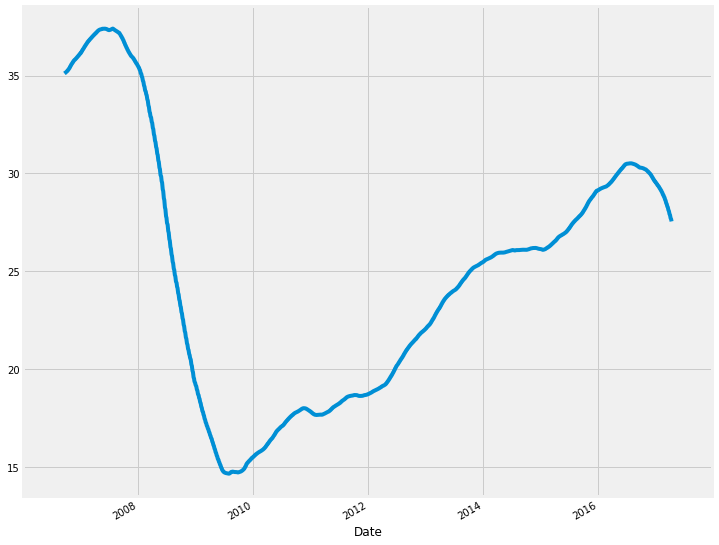

In [27]:
decomposed_ge_volume.trend.plot()

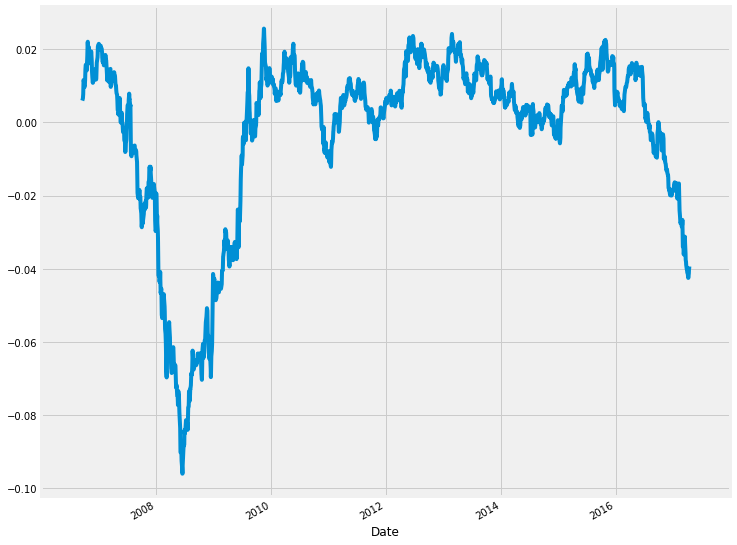

In [28]:
decomposed_ge_volume.trend.diff().plot()

## Моделирование High Prices

В данной части просто попытаемся поиграть с тем как мы можем промоделировать имеющиеся процессы. 
Заметим, High Prices акций нельзя будет продуктивно моделировать без Integrated processes.
Поэтому так и поступим, но не прямо сейчас.

Из того что прямо сейчас - заметим что ряд Volume стационарный и достаточно хороший.

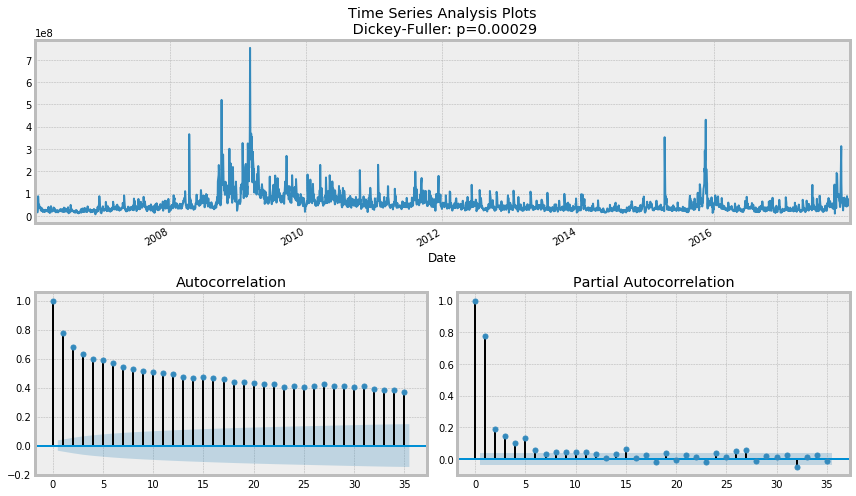

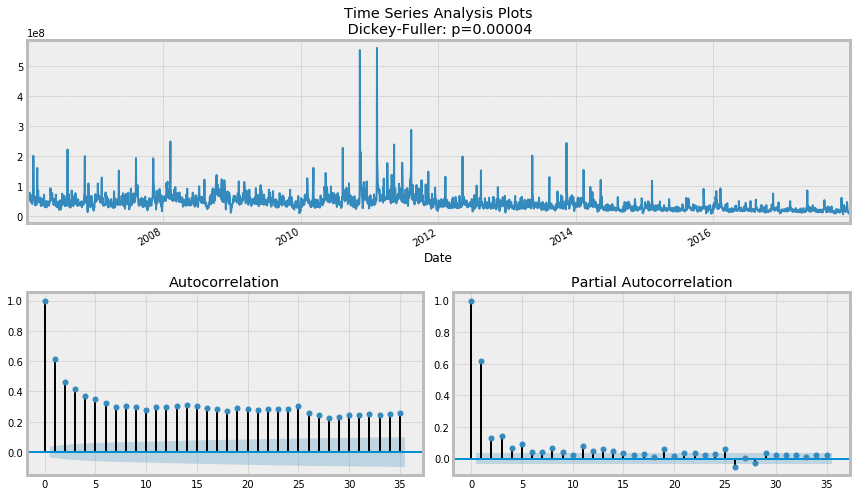

In [29]:
do_plot(ge.Volume)
do_plot(csco.Volume)

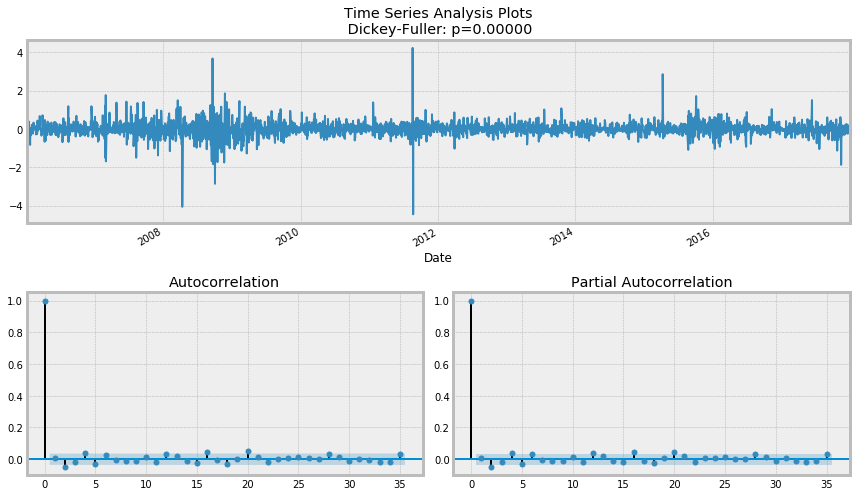

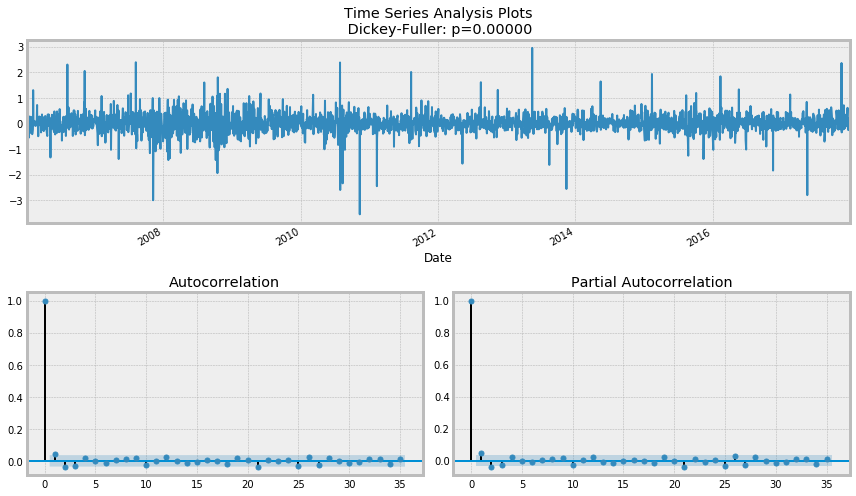

In [30]:
do_plot(ge_diff)
do_plot(csco_diff)

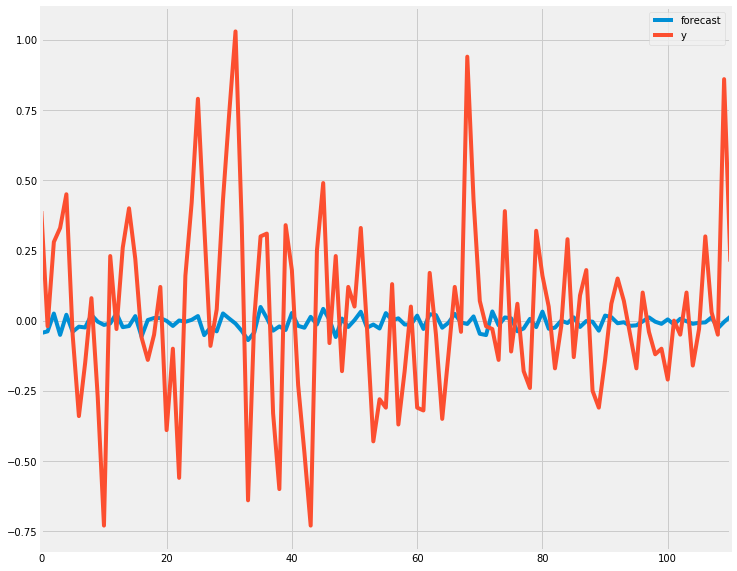

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3019
Model:                     ARMA(9, 0)   Log Likelihood               -1278.165
Method:                       css-mle   S.D. of innovations              0.370
Date:                Wed, 13 May 2020   AIC                           2578.329
Time:                        01:45:08   BIC                           2644.469
Sample:                             0   HQIC                          2602.112
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0059      0.006     -0.920      0.358      -0.019       0.007
ar.L1.y        0.0113      0.018      0.620      0.535      -0.024       0.047
ar.L2.y       -0.0485      0.018     -2.668      0.0

In [31]:
# Predicting General Electric and Cisco AR only
ge_ar = ARMA(ge["High"].diff().iloc[1:].values, order=(9,0))
res = ge_ar.fit()
res.plot_predict(start=900, end=1010)
plt.show()
print(res.summary())

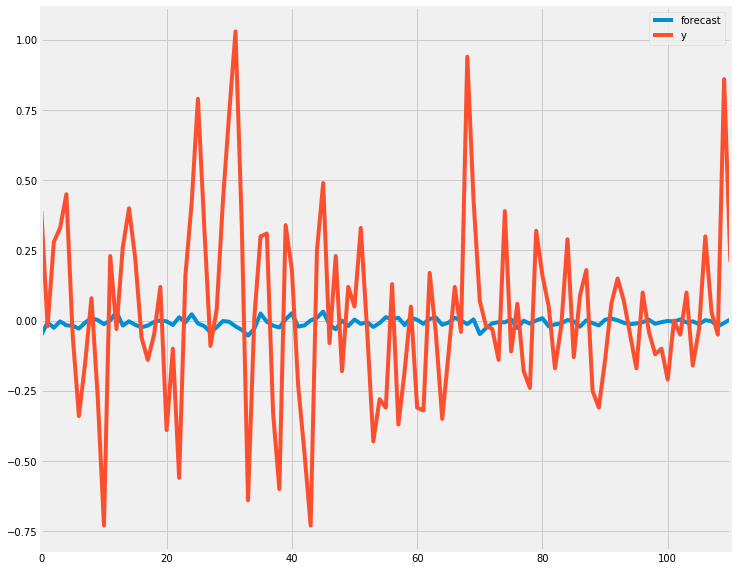

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3019
Model:                     ARMA(2, 0)   Log Likelihood               -1284.572
Method:                       css-mle   S.D. of innovations              0.370
Date:                Wed, 13 May 2020   AIC                           2577.144
Time:                        01:45:11   BIC                           2601.194
Sample:                             0   HQIC                          2585.792
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0059      0.006     -0.913      0.361      -0.019       0.007
ar.L1.y        0.0092      0.018      0.504      0.614      -0.026       0.045
ar.L2.y       -0.0489      0.018     -2.693      0.0

In [32]:
ge_ar = ARMA(ge["High"].diff().iloc[1:].values, order=(2,0))
res = ge_ar.fit()
res.plot_predict(start=900, end=1010)
plt.show()
print(res.summary())

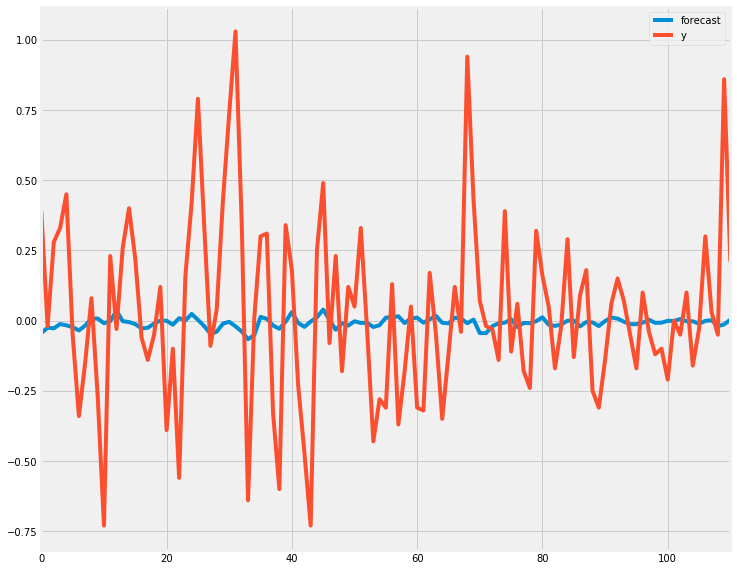

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3019
Model:                     ARMA(0, 3)   Log Likelihood               -1284.198
Method:                       css-mle   S.D. of innovations              0.370
Date:                Wed, 13 May 2020   AIC                           2578.396
Time:                        01:45:12   BIC                           2608.460
Sample:                             0   HQIC                          2589.206
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0059      0.006     -0.931      0.352      -0.018       0.007
ma.L1.y        0.0101      0.018      0.553      0.581      -0.026       0.046
ma.L2.y       -0.0460      0.017     -2.642      0.0

In [33]:
ge_ar = ARMA(ge["High"].diff().iloc[1:].values, order=(0,3))
res = ge_ar.fit()
res.plot_predict(start=900, end=1010)
plt.show()
print(res.summary())

До этого наглядно было показано что просто AR и MA процессами смоделировать исходное распределение данных не удастся.

Внизу будет попытка создать моделирование при помощи ARMA(1,1) но она будет неудачной, хотя ADF тест говорит о стационарности. Жаль что как в VAR нет принудительного остационарирования и т.д.

In [34]:
model = ARMA(ge["High"].diff().iloc[1:].values, order=(1,1))
res = model.fit()
res.plot_predict(start=900, end=1010)
plt.show()
print(res.summary())

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

                           Statespace Model Results                           
Dep. Variable:       ['High', 'High']   No. Observations:                 3019
Model:                     VARMA(1,1)   Log Likelihood               -2336.053
                          + intercept   AIC                           4698.107
Date:                Wed, 13 May 2020   BIC                           4776.272
Time:                        01:46:11   HQIC                          4726.214
Sample:                             0                                         
                               - 3019                                         
Covariance Type:                  opg                                         
Ljung-Box (Q):                  67.67, nan   Jarque-Bera (JB):   75583.08, 35827.01
Prob(Q):                         0.00, nan   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.39, 0.61   Skew:                     -0.16, -0.35
Prob(H) (two-sided):            0.00,

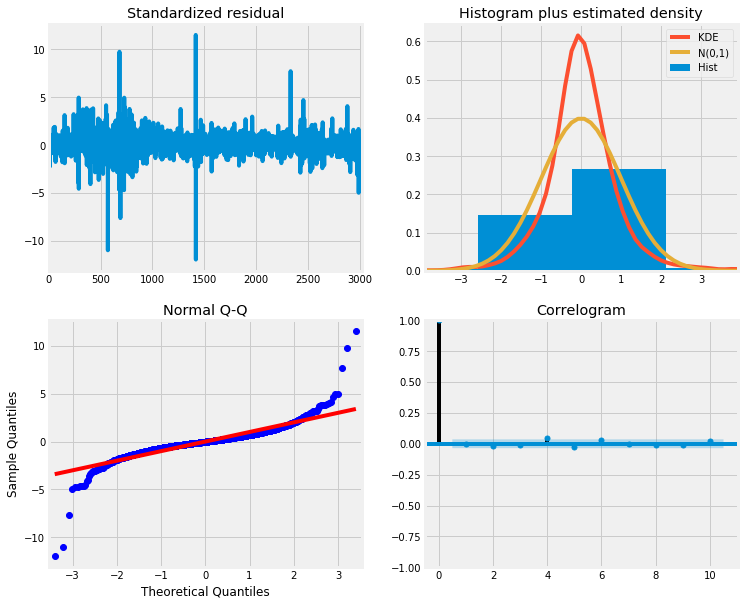

In [35]:
train_sample = pd.concat([ge["High"].diff().iloc[1:],csco["High"].diff().iloc[1:]],axis=1)
model = sm.tsa.VARMAX(train_sample,order=(1,1),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()

rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

                           Statespace Model Results                           
Dep. Variable:       ['High', 'High']   No. Observations:                 3019
Model:                     VARMA(2,2)   Log Likelihood               -2324.117
                          + intercept   AIC                           4690.235
Date:                Wed, 13 May 2020   BIC                           4816.501
Time:                        01:47:29   HQIC                          4735.638
Sample:                             0                                         
                               - 3019                                         
Covariance Type:                  opg                                         
Ljung-Box (Q):                  52.85, nan   Jarque-Bera (JB):   76889.00, 35898.57
Prob(Q):                         0.08, nan   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.39, 0.61   Skew:                     -0.12, -0.36
Prob(H) (two-sided):            0.00,

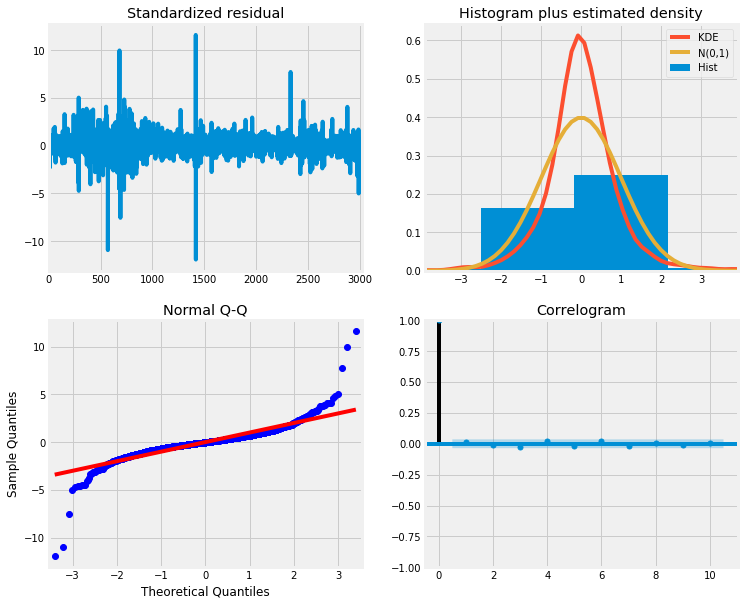

In [36]:
train_sample = pd.concat([ge["High"].diff().iloc[1:],csco["High"].diff().iloc[1:]],axis=1)
model = sm.tsa.VARMAX(train_sample,order=(2,2),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()

rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

Основная цель была конечно попробовать использовать данную модель.
И она конечно не очень хороша. Большинство лагов особенно для Cisco статистически не значимы. Но в целом 2 модели одинаково не очень хороши для этого типа моделирования. Данные по Quantile-Quantile Plot не очень нормально распределены, что видно и по графикам плотности. Хорошие остатки 

# Моделирование для Volume
Затем попроубем промоделировать для общего объёма акций, мы помним что исходный ряд стационарный.

In [37]:
ge_vs = ge.Volume - ge.Volume.shift(1)
csco_vs = csco.Volume - csco.Volume.shift(1)

ge_vs = ge_vs.drop(ge_vs.index[0])
csco_vs = csco_vs.drop(csco_vs.index[0])

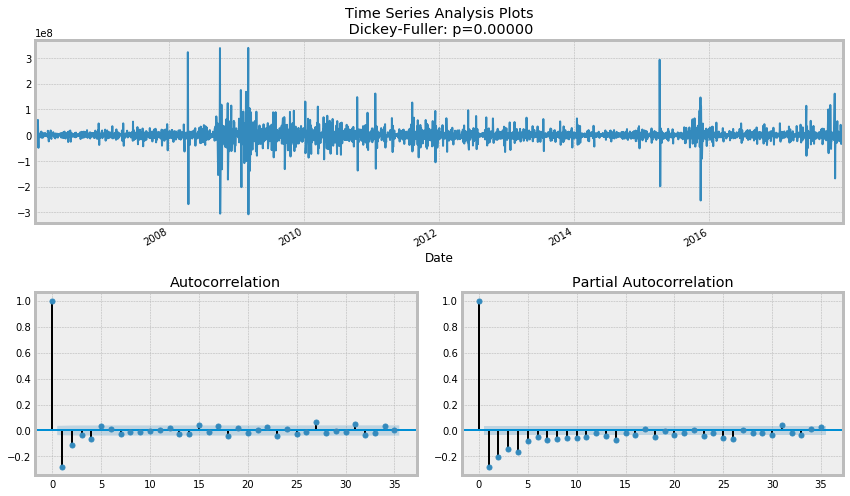

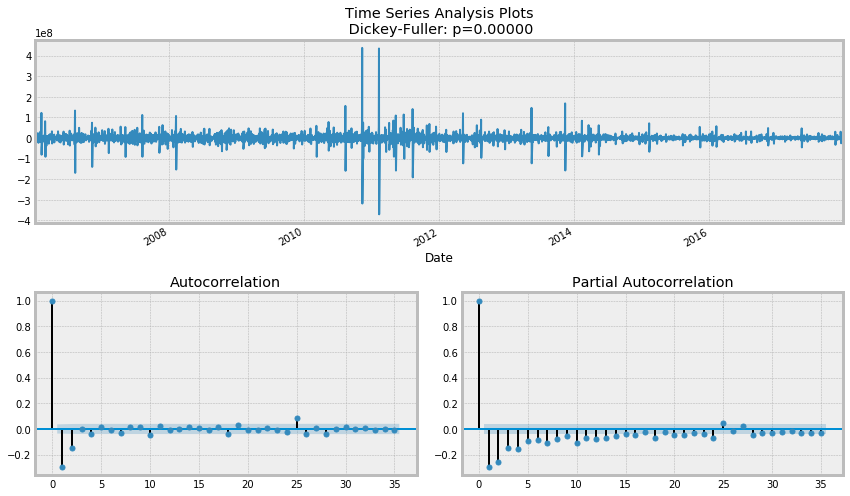

In [38]:
do_plot(ge_vs)
do_plot(csco_vs)

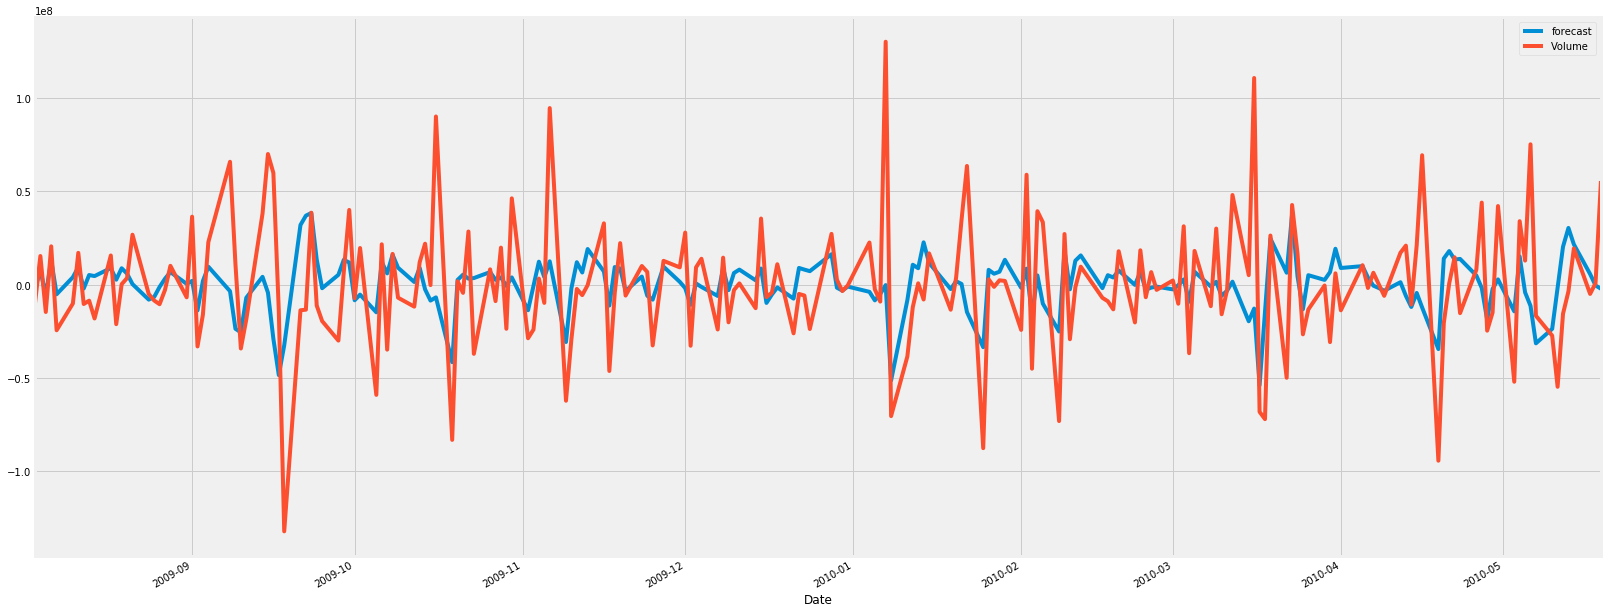

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                 3019
Model:                     ARMA(4, 0)   Log Likelihood              -55931.558
Method:                       css-mle   S.D. of innovations       26896955.732
Date:                Wed, 13 May 2020   AIC                         111873.117
Time:                        01:47:32   BIC                         111903.180
Sample:                             0   HQIC                        111883.927
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.Volume    -0.3902      0.018    -21.739      0.000      -0.425      -0.355
ar.L2.Volume    -0.2923      0.019    -15.427      0.000      -0.329      -0.255
ar.L3.Volume    -0.2031      0.019    -10.72

In [39]:
rcParams['figure.figsize'] = 25, 11
ge_ar = ARMA(ge_vs, order=(4,0))
res = ge_ar.fit(trend='nc') # константа у нас была прямо сильно не значима
res.plot_predict(start=900, end=1100)
plt.show()
print(res.summary())

Хорошая модель с не значашей константой.

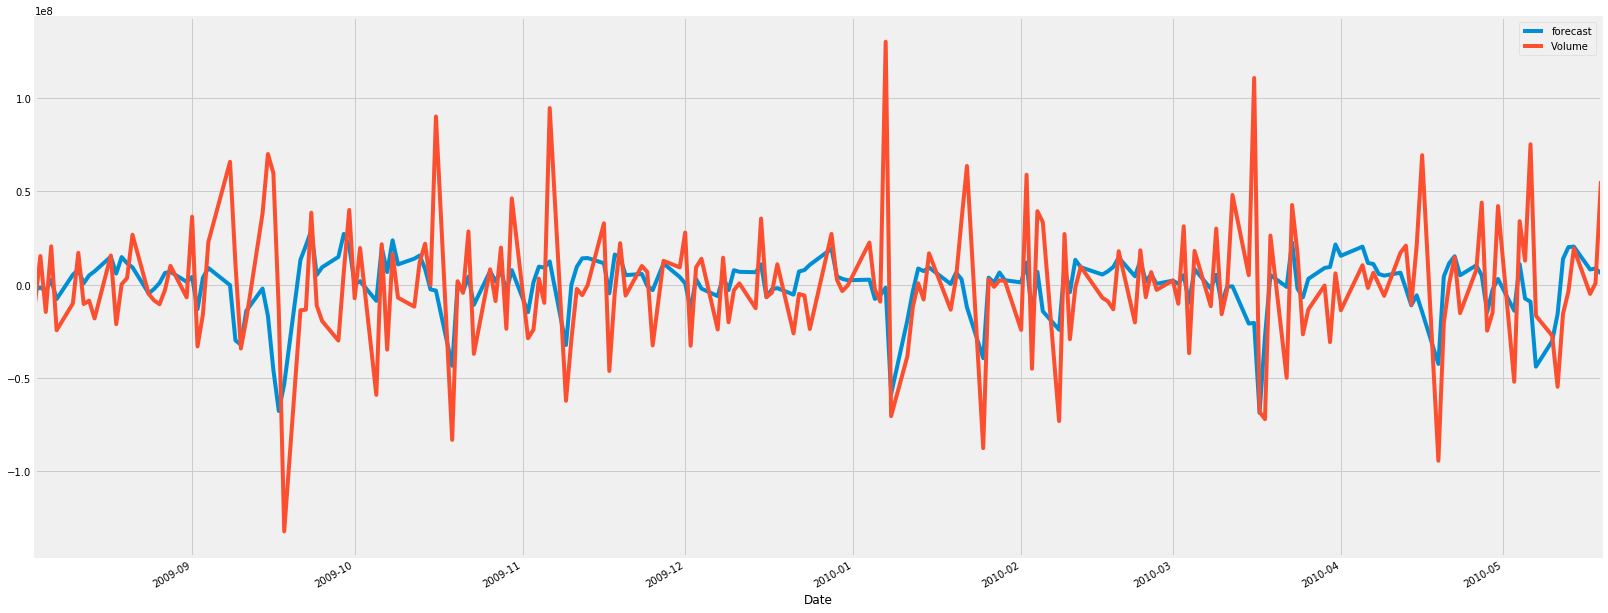

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                 3019
Model:                     ARMA(0, 3)   Log Likelihood              -55889.687
Method:                       css-mle   S.D. of innovations       26525158.034
Date:                Wed, 13 May 2020   AIC                         111787.375
Time:                        01:47:32   BIC                         111811.426
Sample:                             0   HQIC                        111796.023
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ma.L1.Volume    -0.4455      0.018    -24.656      0.000      -0.481      -0.410
ma.L2.Volume    -0.1874      0.022     -8.633      0.000      -0.230      -0.145
ma.L3.Volume    -0.1105      0.019     -5.73

In [40]:
rcParams['figure.figsize'] = 25, 11
ge_ar = ARMA(ge_vs, order=(0,3))
res = ge_ar.fit(trend='nc')
res.plot_predict(start=900, end=1100)
plt.show()
print(res.summary())

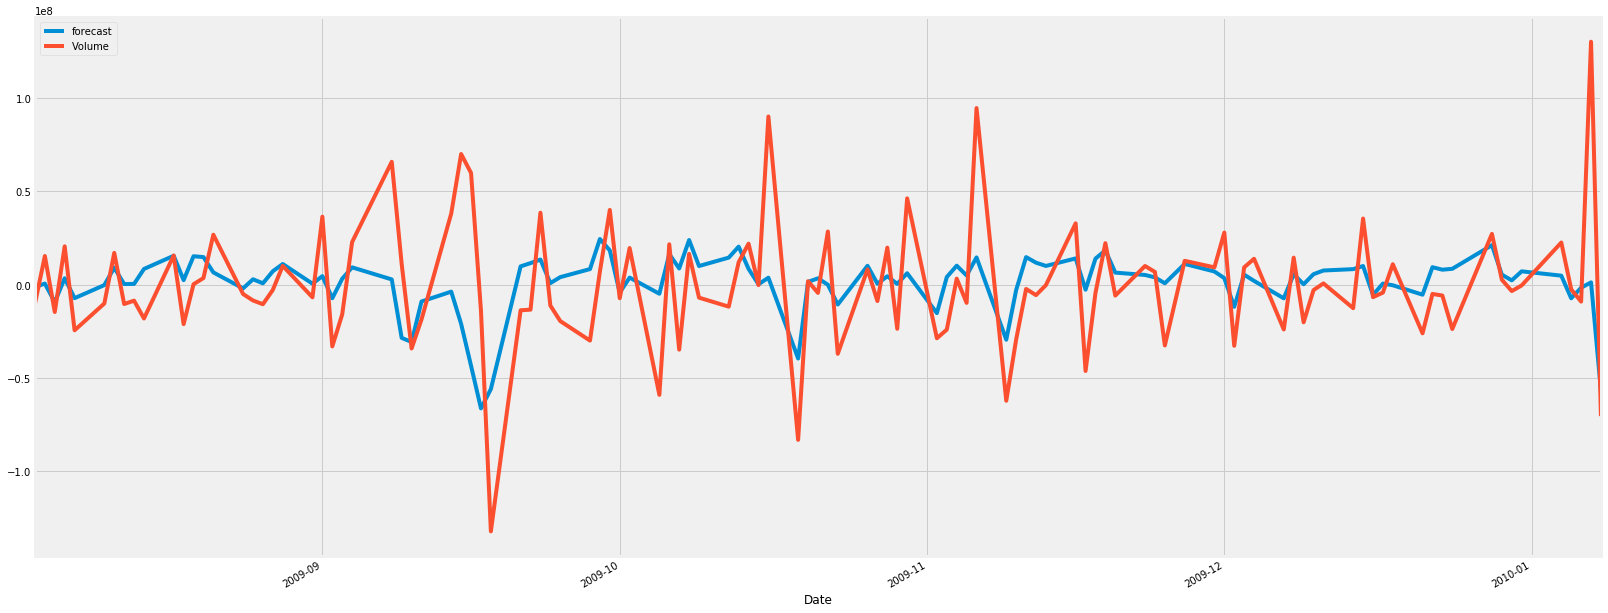

                              ARMA Model Results                              
Dep. Variable:                 Volume   No. Observations:                 3019
Model:                     ARMA(3, 3)   Log Likelihood              -55868.719
Method:                       css-mle   S.D. of innovations       26338060.558
Date:                Wed, 13 May 2020   AIC                         111751.439
Time:                        01:47:37   BIC                         111793.528
Sample:                             0   HQIC                        111766.573
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.Volume    -0.3958      0.026    -15.257      0.000      -0.447      -0.345
ar.L2.Volume    -0.5654      0.024    -23.771      0.000      -0.612      -0.519
ar.L3.Volume     0.4803      0.026     18.67

In [41]:
model = ARMA(ge_vs, order=(3,3))
res = model.fit(trend='nc')
res.plot_predict(start=900, end=1010)
plt.show()
print(res.summary())

                            Statespace Model Results                            
Dep. Variable:     ['Volume', 'Volume']   No. Observations:                 3019
Model:                       VARMA(1,1)   Log Likelihood             -111150.045
Date:                  Wed, 13 May 2020   AIC                         222322.090
Time:                          01:47:42   BIC                         222388.230
Sample:                               0   HQIC                        222345.873
                                 - 3019                                         
Covariance Type:                    opg                                         
Ljung-Box (Q):                  82.38, nan   Jarque-Bera (JB):   418961.10, 3489164.81
Prob(Q):                         0.00, nan   Prob(JB):                      0.00, 0.00
Heteroskedasticity (H):         0.43, 0.29   Skew:                          4.59, 8.87
Prob(H) (two-sided):            0.00, 0.00   Kurtosis:                   59.98, 168.63
    

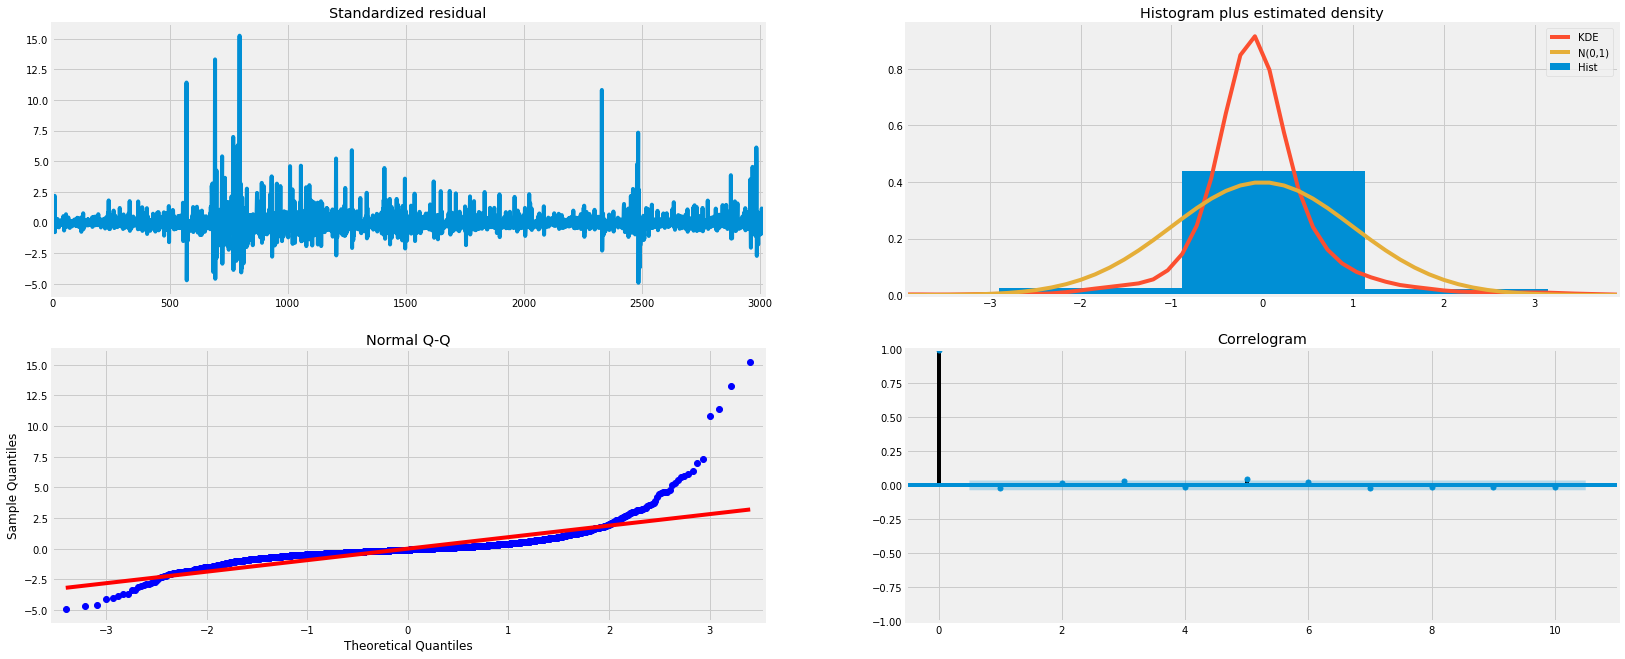

In [42]:
train_sample = pd.concat([ge_vs, csco_vs],axis=1)
model = sm.tsa.VARMAX(train_sample,order=(1,1),trend='nc')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()

rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

Основная цель работы была посмотреть реализацию на питоне, узнать о моделировании AR, MA, ARMA и VAR процессов. 

На основании данных компаний Cisco и General Electric увидели основные тренды в данных наивысшей дневной цены на акции, попробовали смоделирвоать поведение данных величин при помощи простейщих процессов. Это не везде получилось, что наглядно было продемонстрировано на графиках forecast. Странно что ADF тест выдал стационарность, хотя питон не хотел принимать к исполнению ARMA процесс. Построение VAR процессов было продиктовано попыткой протестировать взаимной влияние цен акций включая лаги. Конечно VAR был построен, но питон принудительно остационаривал процесс или обращал процессы. Для показателя высоких цен на акции VAR тестирование конечно провалилось.

Далее было интересно посмотреть как ведём величина Volume. Изначально ADF тест показывал что процесс стационарный. Я подумал что с этим рядом будет работать проще. Квантил квантиль диаграмма конечно тут как и в случае с High price давало не совсем нормально распределение но было принято решение попробовать. НО у данного процесса были не самые хорошие графики ACF and PACF  с далеко идущими значимыми лагами. Ситуаци улучшилась с применеием дифференцирования во второй раз, по крайней мере для ACF. Общее моделирование AR и MA копонентами дало не плохой результат. Построеная ARMA (фактически I=2 от начального) модель тоже дала хорошие результаты. VAR модель не стал применять ибо не совсем понятно как взаимно могут повлиять количество акций, куда интереснее работать с ценами. 

Кроме этого в работе также есть немного отдельных графиков сглаживания рядов, показывания тренда для просмотра динамики.